![Logo do Markdown](logo-ESTB.png)

## Projeto de Big Data
### Realizado por: João Lobato Nº202000071  e Tiago Timóteo Nº202000029


# Índice
- Introdução
- Importing the needed libraries
- Creating a Pyspark session 
- Loading the Dataset
- Data Cleaning and Exploraty Analysis
- Data Pre-processing
- Machine Learning model implementacion 
- Conclusão
- Bibliografia


# Introdução


#### No segundo projeto da unidade curricular de Big Data foi-nos proposta a escolha de um dataset para usarmos as funcionalidades do PySpark e algoritmos de  machine learning. Escolhemos um dataset que contêm os registos de saúde de 110204 internações de pacientes com sepsis. O dataset contêm quatro variáveis sendo elas a idade, o género (0=masculino/1=feminino), o numero do episodio da doença de sepsis e o resultado do hospital (0=paciente faleceu/1=paciente sobreviveu). Iremos usar dois algoritmos de aprendizagem supervisionada, regressão linear e arvore de decisão para, usando as features prever se o paciente falece ou não no hospital. Por fim iremos comparar os resultados dos dois modelos.

# Importing the needed libraries

In [4]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import findspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType, BooleanType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 2. Creating a Spark session

#### Inicializamos uma Sparksession e atribuimos o nome "ML-Project" a nossa aplicação.

In [5]:
#Add and set pyspark
findspark.init()

#Create an object of spark session
spark = SparkSession.builder.appName("Ml-Project").getOrCreate()

# 3. Loading the dataset

#### Obtemos o dataset do site: https://archive.ics.uci.edu/ml/datasets/Sepsis+survival+minimal+clinical+records

In [6]:
#Read the csv file
df = spark.read.csv('s41598-020-73558-3_sepsis_survival_primary_cohort.csv', header=True, sep=",")

#Show the first 5 lines of the dataset
df.show(5,0)

+---------+-----------------+--------------+-----------------------------+
|age_years|sex_0male_1female|episode_number|hospital_outcome_1alive_0dead|
+---------+-----------------+--------------+-----------------------------+
|21       |1                |1             |1                            |
|20       |1                |1             |1                            |
|21       |1                |1             |1                            |
|77       |0                |1             |1                            |
|72       |0                |1             |1                            |
+---------+-----------------+--------------+-----------------------------+
only showing top 5 rows



# 4. Data Cleaning and Exploraty Analysis

#### Primeiramente fomos analizar a dimensão do dataset.

In [7]:
#Check the dimensions of the dataset
df.count(), len(df.columns)

(110204, 4)

#### Depois fomos observar quais eram as caracteristicas das variáveis.

In [8]:
#Check the datatypes of the variables
df.dtypes

[('age_years', 'string'),
 ('sex_0male_1female', 'string'),
 ('episode_number', 'string'),
 ('hospital_outcome_1alive_0dead', 'string')]

#### Como as variáveis escontravam-se todas em tipo String foi necessario mudar as variáveis para as respetivas caracteristicas.

In [9]:
#Changing the datatype of the variables 
df = df \
    .withColumn("age_years", df["age_years"].cast(IntegerType())) \
    .withColumn("sex_0male_1female", df["sex_0male_1female"].cast(BooleanType())) \
    .withColumn("episode_number", df["episode_number"].cast(IntegerType())) \
    .withColumn("hospital_outcome_1alive_0dead", df["hospital_outcome_1alive_0dead"].cast(IntegerType()))

#### Voltando a analizar verificamos que todas as variáveis se encontram na caracteristica adequada.

In [10]:
#Check the datatypes of the variables
df.dtypes

[('age_years', 'int'),
 ('sex_0male_1female', 'boolean'),
 ('episode_number', 'int'),
 ('hospital_outcome_1alive_0dead', 'int')]

#### Fizemos a sumarização de todas as variáveis apresentando:
- Contagem de atributos que apresentam no dataset;
- Média de cada variável;
- Descio-padrão;
- Valor minímo de cada variável;
- Valor máximo de cada variável.

In [11]:
# Summarizing some information about the variables
df.describe().show()

+-------+------------------+------------------+-----------------------------+
|summary|         age_years|    episode_number|hospital_outcome_1alive_0dead|
+-------+------------------+------------------+-----------------------------+
|  count|            110204|            110204|                       110204|
|   mean|62.735254618707124|  1.34937933287358|           0.9264545751515372|
| stddev|24.126805712867906|0.7517985207617897|          0.26103086716707735|
|    min|                 0|                 1|                            0|
|    max|               100|                 5|                            1|
+-------+------------------+------------------+-----------------------------+



#### Criamos uma coluna para indicar a quais idades apresentam uma maior frequência de episodios de sepsis.

In [12]:
#See what ages have the higher number of episodes
df_freq = df.groupBy('age_years').agg(count('episode_number').alias('frequency'))
df_freq.orderBy(desc('frequency')).show()

+---------+---------+
|age_years|frequency|
+---------+---------+
|       82|     2665|
|       84|     2621|
|       81|     2541|
|       83|     2523|
|       80|     2520|
|       86|     2467|
|       79|     2428|
|       85|     2422|
|       87|     2372|
|       68|     2289|
|       67|     2247|
|       66|     2242|
|       78|     2190|
|       74|     2181|
|       65|     2179|
|       88|     2153|
|       73|     2146|
|       75|     2112|
|       76|     2090|
|       77|     2077|
+---------+---------+
only showing top 20 rows



#### Por ultimo fomos conferir se existia valores nulos.

In [13]:
#Checking for null data
data_agg = df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns])
data_agg.show()

+---------+-----------------+--------------+-----------------------------+
|age_years|sex_0male_1female|episode_number|hospital_outcome_1alive_0dead|
+---------+-----------------+--------------+-----------------------------+
|        0|                0|             0|                            0|
+---------+-----------------+--------------+-----------------------------+



# 5. Data Pre-processing

#### Primeiramente criamos um vetor para todas as features.

In [14]:
#Specification of the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['age_years', 'sex_0male_1female', 'episode_number'], outputCol='features')

#Transforming the data
assembler = assembler.transform(df)

#View of the tranformed vector
assembler.select('features', 'hospital_outcome_1alive_0dead')

DataFrame[features: vector, hospital_outcome_1alive_0dead: int]

#### Standardizamos os dados das features, para prevenir que as variáveis com grandes escalas dominassem o modelo.

In [15]:
#Standardization of the features
scale = StandardScaler(inputCol='features', outputCol='standardize')

#Fitting and tranformation of the vector
data_scale=scale.fit(assembler)
data_scale_output=data_scale.transform(assembler)

#Show the first five lines of the standerdized data
data_scale_output.select('standardize').show(5, 0)

+---------------------------------------------------------+
|standardize                                              |
+---------------------------------------------------------+
|[0.8704011732808795,2.002711214904269,1.3301436121298966]|
|[0.8289534983627423,2.002711214904269,1.3301436121298966]|
|[0.8704011732808795,2.002711214904269,1.3301436121298966]|
|[3.1914709686965583,0.0,1.3301436121298966]              |
|[2.9842325941058725,0.0,1.3301436121298966]              |
+---------------------------------------------------------+
only showing top 5 rows



In [16]:

model_df = data_scale_output.select(['features', 'hospital_outcome_1alive_0dead'])
model_df = model_df.withColumnRenamed("hospital_outcome_1alive_0dead", "label")
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



# 6. Machine Learning model implementacion

#### Dividimos o dataset em dois, um para treino e outro para teste.

In [17]:
#Spliting randomly the dataset into training and testing dataframes 
train_df, test_df = model_df.randomSplit([0.7, 0.3])

#### Criamos o modelo de Regressão Linear.

In [18]:
#Creating the logistic regression model object
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label').fit(train_df)

#### Sumarização e análise da precisão do modelo de regressão linear.

In [19]:
#Creating a variable with the summarized data of the model
lr_summary = log_reg.summary

In [20]:
#Overall accuracy of the classification model
lr_summary.accuracy

0.9265477303417472

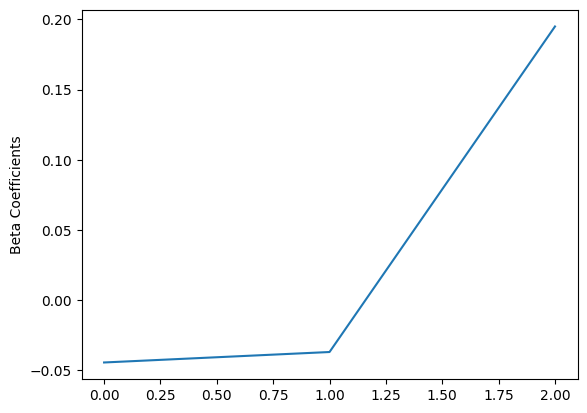

In [21]:

beta = np.sort(log_reg.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

#### O resultado do gráfico indica-nos que a abilidade de saber se um paciente faleceu ou não, é aceitavel.

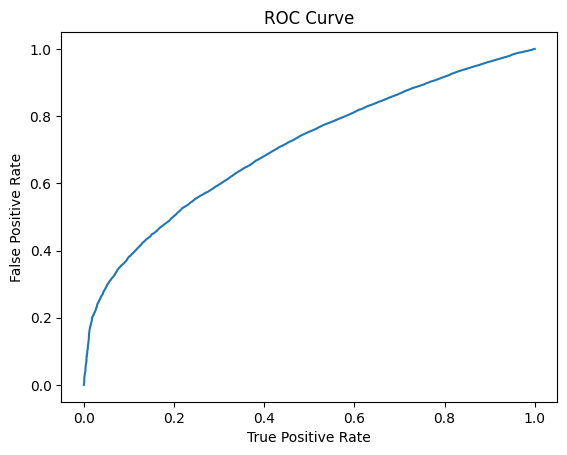

Training set areaUnderROC: 0.7062828238366888


In [22]:
#Summarizing the model over the training dataset to obtain the areaUnderROC and the receiver-operating characteristic
roc = lr_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(lr_summary.areaUnderROC))

#### A curva neste gráfico contêm TP/(TP+FN) no eixo do y e TP/(TP+FP) no eixo do x. O grafico ajuda a entender que o nosso modelo teve uma boa precisão. 

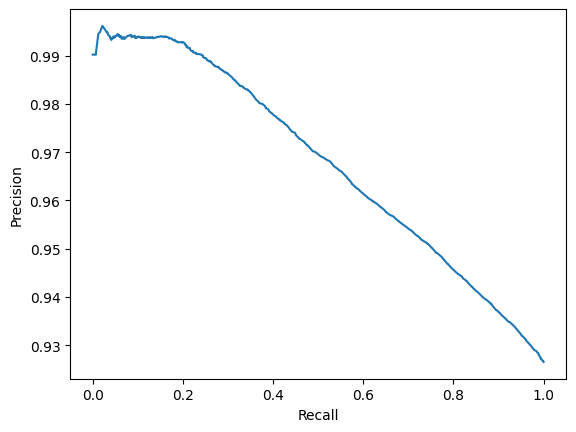

In [23]:
pr = lr_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Fomos comparar os valores que reais e os valores que o modelo preveu.

In [24]:
prediction = log_reg.transform(test_df)
prediction.select('label', 'prediction').show(20)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



#### Fomos criar outro modelo, uma arvore de decisão, usando os dados de treino e de teste já preparados para o outro modelo.

In [25]:
# Defining the decision tree classifier model and fit the model on the training data
clf = DecisionTreeClassifier(featuresCol='features', labelCol='label')
clf = clf.fit(train_df)

pre = clf.transform(test_df)
pre.show(5, 0)

+-------------+-----+----------------+----------------------------------------+----------+
|features     |label|rawPrediction   |probability                             |prediction|
+-------------+-----+----------------+----------------------------------------+----------+
|[0.0,0.0,1.0]|0    |[5657.0,71359.0]|[0.07345226965825283,0.9265477303417472]|1.0       |
|[0.0,0.0,1.0]|0    |[5657.0,71359.0]|[0.07345226965825283,0.9265477303417472]|1.0       |
|[0.0,0.0,1.0]|0    |[5657.0,71359.0]|[0.07345226965825283,0.9265477303417472]|1.0       |
|[0.0,0.0,1.0]|1    |[5657.0,71359.0]|[0.07345226965825283,0.9265477303417472]|1.0       |
|[0.0,0.0,1.0]|1    |[5657.0,71359.0]|[0.07345226965825283,0.9265477303417472]|1.0       |
+-------------+-----+----------------+----------------------------------------+----------+
only showing top 5 rows



#### Por fim testamos a precisão deste modelo.

In [26]:
eval = MulticlassClassificationEvaluator(predictionCol="prediction")
accur = eval.evaluate(pre)
 
print("Accuracy: ", accur)

Accuracy:  0.8907698785576342
